# 4️⃣ Clustering Analysis
**designed by:** [datamover.ai](https://www.datamover.ai)

In [10]:
# Load libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree

from r3_helpers import chain_snap
from r4_helpers import PCA_analysis, tSNE

np.random.seed(42)

pd.options.display.float_format = "{:.3f}".format
pd.set_option("display.width", 1000)

In [11]:
data = (
    pd.read_parquet("./data/data_train_cleaned.parquet")
    .pipe(
        chain_snap,
        fn=lambda x: x.duplicated().sum(),
        msg="o Number of duplicate rows",
    )
    .pipe(
        chain_snap,
        fn=lambda x: x.isna().sum().sum(),
        msg="o Number of missing values in the dataset",
    )
)

TARGET = "log(Price)"  # we consider the log of the price as the target variable

# display some info
display(data.head(3))
print(f"o Size dataframe = {data.shape}")

o Number of duplicate rows: 0
o Number of missing values in the dataset: 8


,Price,Address,Zip,Area,Room,Lon,Lat,log(Price),Zip_num,Region,Location,District,Delivery_area,AR-ratio,log(AR-ratio),log(Area),log(Room),Euclidean_distance,Haversine_distance,Manhattan_distance
0,425000,"Lamarckhof 11 I, Amsterdam",1098TK,68,3,4.944,52.352,12.960,1098,0,9,8,TK,22.667,3.121,4.220,1.099,0.055,4.174,0.072
1,520000,"Kiefskamp 24, Amsterdam",1082KA,80,2,4.872,52.330,13.162,1082,0,8,2,KA,40.000,3.689,4.382,0.693,0.048,4.959,0.063
2,700000,"Latherusstraat 54, Amsterdam",1032EC,123,6,4.915,52.393,13.459,1032,0,3,2,EC,20.500,3.020,4.812,1.792,0.030,2.712,0.042


o Size dataframe = (739, 20)


In [12]:
# display missing values
display(data.isna().sum().to_frame("Missing values").T)

data = (
    data
    # remove missing values
    .dropna(how="any")
    # Drop Price, Room and Area as we will consider their corresponding log values
    .drop(columns=["Price", "Room", "Area"], axis=1)
    # Drop Address, Lat, Lon and Zip as we have engineered features in the previous section
    .drop(columns=["Address", "Lat", "Lon", "Zip"], axis=1)
    # Drop City as its variance = 0 and Delivery_area as it has too many categories
    .drop(columns=["Zip_num", "Delivery_area"], axis=1)
)

display(data.head(3))

,Price,Address,Zip,Area,Room,Lon,Lat,log(Price),Zip_num,Region,Location,District,Delivery_area,AR-ratio,log(AR-ratio),log(Area),log(Room),Euclidean_distance,Haversine_distance,Manhattan_distance
Missing values,4,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0


,log(Price),Region,Location,District,AR-ratio,log(AR-ratio),log(Area),log(Room),Euclidean_distance,Haversine_distance,Manhattan_distance
0,12.960,0,9,8,22.667,3.121,4.220,1.099,0.055,4.174,0.072
1,13.162,0,8,2,40.000,3.689,4.382,0.693,0.048,4.959,0.063
2,13.459,0,3,2,20.500,3.020,4.812,1.792,0.030,2.712,0.042


**Apply PCA analysis**
 

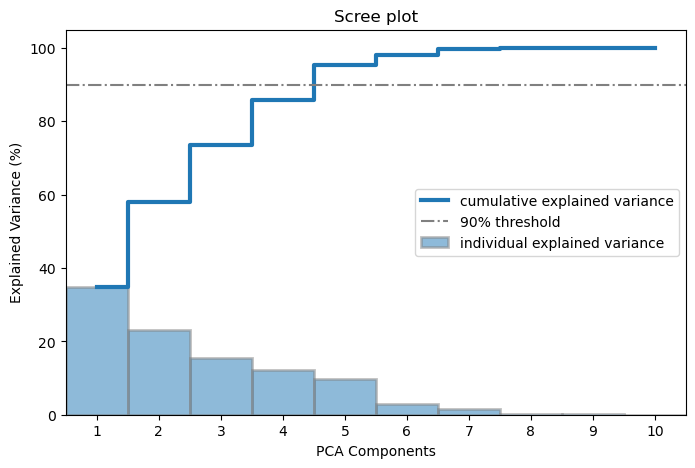

In [13]:
X_features = data.drop(columns=TARGET)

(pca_summary, pca_features, summary_input, pca_components, fig) = PCA_analysis(
    X_features, n_components=5, plot=True, figsize=(8, 5)
)

In [14]:
pca_summary

,pca_component,explained_variance_pct,cumulative_explained_variance_pct
0,1,34.950,34.950
1,2,23.210,58.150
2,3,15.410,73.560
3,4,12.170,85.730
4,5,9.610,95.340
5,6,2.820,98.160
6,7,1.530,99.700
7,8,0.210,99.910
8,9,0.090,100.000
9,10,0.000,100.000


In [15]:
pca_features

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
0,0.080,-0.726,-0.650,1.745,-0.669
1,-0.392,0.976,1.357,1.578,1.604
2,-0.653,0.093,-1.615,-1.550,0.750
3,4.307,0.070,1.900,-1.365,0.493
4,0.630,-0.163,-0.575,-0.458,-1.959
...,...,...,...,...,...
730,-1.397,-0.390,0.093,-0.381,1.247
731,-1.395,1.532,-1.555,0.368,-0.400
732,0.721,-0.851,-0.566,-0.662,-0.023
733,-1.869,-2.478,0.804,-0.125,0.949


In [16]:
summary_input

,PCA_inputs,nsample_input,Nan_values,nsample_pca,noutliers
0,Region,735,0,735,66
1,Location,735,0,735,0
2,District,735,0,735,0
3,AR-ratio,735,0,735,4
4,log(AR-ratio),735,0,735,4
5,log(Area),735,0,735,6
6,log(Room),735,0,735,2
7,Euclidean_distance,735,0,735,2
8,Haversine_distance,735,0,735,2
9,Manhattan_distance,735,0,735,4


In [11]:
pca_components

,Region,Location,District,AR-ratio,log(AR-ratio),log(Area),log(Room),Euclidean_distance,Haversine_distance,Manhattan_distance
comp1,0.369,-0.103,0.127,-0.011,-0.008,0.122,0.151,0.507,0.520,0.521
comp2,-0.086,-0.074,0.090,0.543,0.577,0.543,0.221,-0.048,-0.049,-0.051
comp3,0.290,-0.310,-0.097,0.352,0.304,-0.378,-0.670,-0.011,0.028,0.034
comp4,-0.418,0.709,0.268,0.171,0.135,-0.164,-0.294,0.223,0.138,0.146
comp5,0.079,0.348,-0.917,0.069,0.068,0.074,0.038,0.055,0.087,0.070
comp6,-0.747,-0.512,-0.230,0.047,-0.075,-0.064,-0.021,0.302,0.090,0.121
comp7,0.065,0.036,0.020,0.738,-0.603,-0.182,0.225,-0.043,-0.014,-0.005
comp8,-0.116,-0.029,0.006,-0.003,-0.003,-0.009,-0.009,-0.461,0.827,-0.298
comp9,0.123,0.018,0.004,0.015,-0.005,-0.000,0.004,0.618,0.085,-0.771
comp10,0.000,-0.000,0.000,0.000,-0.427,0.691,-0.583,0.000,-0.000,-0.000


**Apply t-SNE**

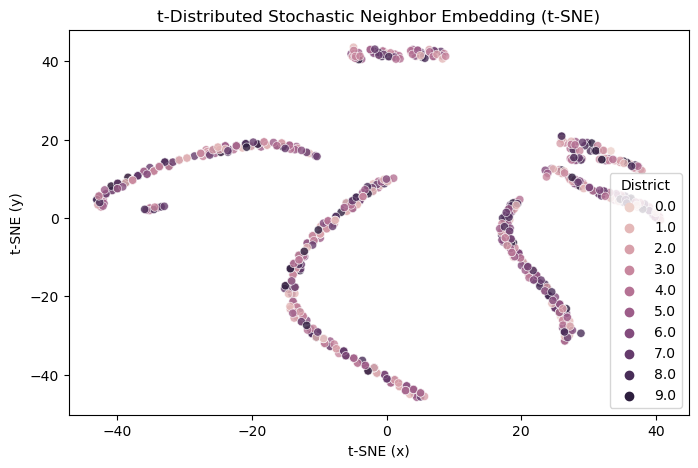

In [28]:
fig = tSNE(
    data.filter(items=["Region", "log(Area)", 'log(Room)', 'Euclidian_distance', "District"]),
    n_components=2,
    hue="District",
    perplexity=30.0,
    figsize=(8, 5),
    generate_plot=False,
)